In [2]:
from pathlib import Path
import xarray as xr
import re
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import re
import seaborn as sns
import matplotlib
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter 

fatal: not a git repository (or any of the parent directories): .git


##  First plotting of urchin trajectories

In [ ]:
use_cached_hm_concat = True
use_cached_yearly_heatmaps = True
save_yearly_heatmaps = False

In [3]:
out_path = "/gxfs_work/geomar/smomw122/smomw529_2023_sea_urchin_tenerife/comp_output_data/full_weekly_runs/"
year_list = np.arange(2007,2017).tolist()
out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24


def read_output(file):
    ds = xr.open_dataset(file)#just use output_paticles for new data
    
    return ds


def load_ds(year):
    
    out_path = "/gxfs_work/geomar/smomw122/smomw529_2023_sea_urchin_tenerife/comp_output_data/full_weekly_runs/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))

    ds = xr.concat(map(read_output, out_files), dim="traj")
    print(f'loaded {len(out_files)} files in year {year}')
    return ds, len(out_files)



In [3]:
%%time
out_ds,num = load_ds(2007)
out_ds
display(out_ds)
print(out_ds.nbytes / 1e9, "GiB")

loaded 52 files in year 2007


<xarray.Dataset>
Dimensions:     (traj: 520000, obs: 182)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.47 -16.51 -16.52 ... -16.54 -16.54 nan
    lat         (traj, obs) float64 28.12 28.11 28.05 28.03 ... 28.04 28.04 nan
    z           (traj, obs) float64 28.72 28.74 48.87 46.02 ... 26.71 26.71 nan
    time        (traj, obs) datetime64[ns] 2007-01-01 2007-01-02 ... NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 9.999e+03 9.999e+03 nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

3.7856 GiB
CPU times: user 3.11 s, sys: 2.69 s, total: 5.81 s
Wall time: 11.7 s


In [4]:
def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map


In [5]:
def calc_mort_heatmap(data, lat_bins,lon_bins,photo = False ):

    
    data = data.copy()

    if photo:
        print('mortality; with photos.')
        m = -0.092683473
        data = data.isel(obs = slice(0,181))

    else:
        print('mortality; without photos.')
        m = -0.164783335
        data = data.isel(obs = slice(0,101))

    t = data.obs
    n0 = data.traj.size

    #weight = np.exp(m*t)
    weight = xr.ones_like(data.obs)


    int_heat = calculate_heatmap(data.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins)

    mort_heatmap = (int_heat * weight[:-1]).sum('obs')

    #analytical integ. particles
    particle_sum = int(np.sum(n0 * np.exp(m*t)))
    #diff to integ.mortality heatmap
    err_diff = mort_heatmap.sum()-particle_sum
    print(f'Difference to integr. particles: {err_diff.values}')

    return mort_heatmap,weight#particle_sum

In [6]:
#load velocity data mean
data_path = Path("/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")

x_lines = [-25, -20,-15,-10]
y_lines = [16,18,20,22,24,26,28,30]

u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

ulat = ds_u.coords["nav_lat"].values[:,0]
ulon = ds_u.coords["nav_lon"].values[0,:]

y_ind = np.where((ulat > y_lines[0]) & (ulat < 30))[0]
x_ind = np.where((ulon > x_lines[0]) & (ulon < x_lines[-1]))[0]
    
u_conc = ds_u[:,:,y_ind,x_ind].mean("depthu").mean('time_counter')
v_conc = ds_v[:,:,y_ind,x_ind].mean("depthv").mean('time_counter')

In [7]:
#load_10year mean velocity data

#
for year in year_list[1:]:
    u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc"))
    v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc"))
    
    ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,y_ind,x_ind].mean("depthu").mean('time_counter')
    ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,y_ind,x_ind].mean("depthv").mean('time_counter')
    
    u_conc = xr.concat((u_conc, ds_u), dim = 'year')
    v_conc = xr.concat((v_conc, ds_v), dim = 'year')
    
u_mean = u_conc.mean('year')
v_mean = v_conc.mean('year')

In [7]:
#t_grid bathy
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"
t = xr.open_dataset(data_path / t_file)

t_lat = t.coords["nav_lat"].values[1:,0]
t_lon = t.coords["nav_lon"].values[0,:]

t_sel = t.vosaline[:,:,y_ind,x_ind].sel(time_counter = "2011-01-01")

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int') #depth of cell
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[x_ind],t_lat[y_ind])

lat_bins = t_sel.coords['nav_lat'].values[:,0]#change lat bins to VIKING resolution
lon_bins = t_sel.coords['nav_lon'].values[0,:]
#old bin sizes

In [8]:
#bin coords along t_grid (full resolution)

#dlat = 0.1 #binsize
#dlon = 0.1
#lat_bins = np.arange(20, 32 + dlat, dlat)
#lon_bins = np.arange(-25, -10 + dlon, dlon)


def yearly_heatmap(year):
    ds,num = load_ds(year)
    heatmap = calculate_heatmap(ds, lat_bins, lon_bins)
    return heatmap,num


heatmap_list = year_list.copy()
scale_list = year_list.copy()

for i, year in enumerate(year_list):
    
    heatmap_list[i], scale_list[i] = yearly_heatmap(year)

print(f'number of weeks loaded: {np.array(scale_list).sum()}')

#calc mean and std of ensemble
hm_concat = xr.concat(heatmap_list, dim = 'year')

loaded 52 files in year 2007
loaded 52 files in year 2008
loaded 52 files in year 2009
loaded 52 files in year 2010
loaded 52 files in year 2011
loaded 52 files in year 2012
loaded 52 files in year 2013
loaded 52 files in year 2014
loaded 52 files in year 2015
loaded 52 files in year 2016
number of weeks loaded: 520


In [8]:
#load from netcdf
try:
    use_cached_hm_concat
except NameError:
    use_cached_hm_concat = True

hm_concat_path = Path("../data/heatmaps_1st_gen.nc")
if use_cached_hm_concat and hm_concat_path.exists():
    hm_concat = xr.open_dataarray(hm_concat_path)

#save to netcdf
#hm_concat.to_netcdf(hm_concat_path)

ensemble_mean = hm_concat.sum('obs').mean('year')
ensemble_std = hm_concat.sum('obs').std('year', ddof = 1)

ensemble_100_mean = hm_concat.isel(obs = slice(0,101)).sum('obs').mean('year')


In [1]:
try:
    use_cached_yearly_heatmaps
except NameError:
    use_cached_yearly_heatmaps = True

try:
    save_yearly_heatmaps
except NameError:
    save_yearly_heatmaps = False

heatmap_list = year_list.copy()
for i,year in enumerate(year_list):
    hm_name = Path(f"../data/heatmaps_1st_gen{year}.nc")

    if use_cached_yearly_heatmaps and hm_name.exists():
        heatmap_list[i] = xr.open_dataarray(hm_name)
    else:
        heatmap_list[i], _ = yearly_heatmap(year)
        if save_yearly_heatmaps:
            heatmap_list[i].to_netcdf(hm_name)


NameError: name 'year_list' is not defined

NameError: name 'u_mean' is not defined

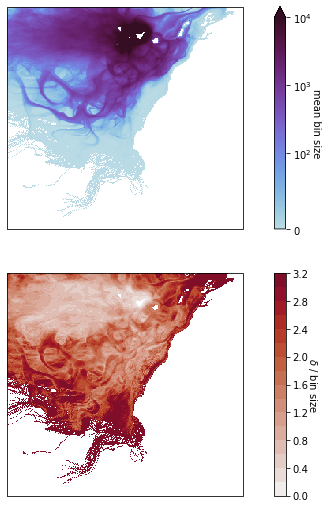

In [10]:

ticks = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
cb_pad = 0.07
cb_fraction = 0.047
proj = ccrs.PlateCarree()
box_size = 0.25
box_lon = -16.3
box_lat = 28.4
textbox = ["0-181 days\nensemble mean","0-181 days\nstandard deviation"]
textbox2 = ["a)","b)"]
cmap = cmocean.cm.dense
new_cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)

#percentiles
lon = ensemble_mean["lon_bin"]
lat = ensemble_mean["lat_bin"]
quants = ensemble_mean.quantile(q=0.95) # 95% percentile
quants_low = ensemble_mean.quantile(q=0.50) # 50% percentile
hm_t = quants.coords["quantile"].where(ensemble_mean > quants)
hm_tlow = quants.coords["quantile"].where(ensemble_mean > quants_low)




fig, axs = plt.subplots(2, 1, subplot_kw={"projection": proj}, figsize=(16, 9))
#fig, axs = plt.subplots(2, 1, subplot_kw={"projection": proj}, figsize=(20, 10))

axs = axs.flatten()

mesh1 = ensemble_mean.where(ensemble_mean > 0).plot(ax = axs[0],cmap = new_cmap,add_colorbar=False,norm=colors.SymLogNorm(linthresh=100, linscale=1,
                                                       vmin=0, vmax=1e4,
                                                                     base=10), extend = 'max')#, zorder = )
cbar = fig.colorbar(mesh1, ax =axs[0], pad = cb_pad*0.5, extend = 'max')
#cbar = axs[0].collections[-1].colorbar
cbar.set_label('mean bin size', rotation=270,labelpad = 10)




mesh2 = (ensemble_std/ensemble_mean).where(hm_tlow > 0).plot(ax = axs[1],cmap = cmocean.tools.crop_by_percent(cmocean.cm.amp, 20, which='max', N=None),
                                                             levels = 21,add_colorbar=False)#norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       #vmin=0, vmax=1e5,
    #              base=10), extend = 'both')#, zorder = 
cbar = fig.colorbar(mesh2, ax =axs[1], pad = cb_pad*0.5)
    #cbar = axs[1].collections[0].colorbar
cbar.set_label('$\delta$ / bin size', rotation=270,labelpad = 10)

for i, ax in enumerate(axs.flat):
    
    if i ==3:
        fig.delaxes(ax)
        break
        
    skip = 10
    qv = ax.quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 2.5,
            transform = proj)
    ax.quiverkey(qv, .55, .52, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure')
    ax.annotate(textbox[i],(-16.1,20.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    ax.annotate(textbox2[i],(-24.5,29.),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc
    
    
    #ax.contour(lon,lat, hm_tlow.fillna(0), colors = "00", linewidths = 0.1,antialiased = False)
        #misc
    ax.coastlines()
        
    ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)

    #ax.set_extent((x_lines[0],x_lines[-1],19,30)) 
    ax.set_xticks(x_lines, crs=proj)
    ax.set_yticks(y_lines, crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 
    ax.set_extent((x_lines[0],x_lines[-1],17,30))
    ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
    ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.4,antialiased = False, levels = [500])


            
    plt.tight_layout()

            #cbar.set_ticks(ticks, format = formatter)
            #cbar.set_ticklabels(ticks)
#plt.savefig('pics/ensemble_mean_std.png', dpi = 300, bbox_inches = 'tight')            

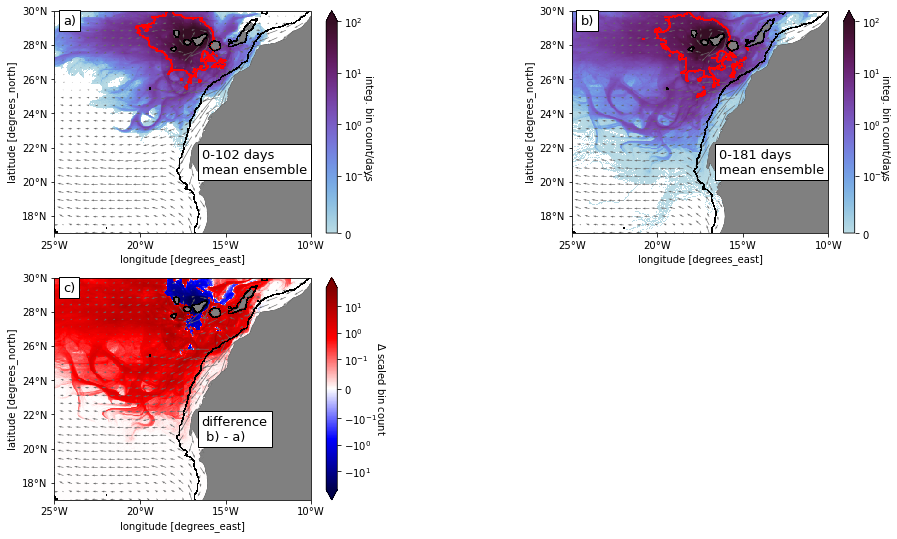

In [20]:
import matplotlib.ticker as mticker

textbox = ["0-102 days\nmean ensemble","0-181 days\nmean ensemble",'difference\n b) - a)']
textbox2 = ["a)","b)", "c)"]


quants = ensemble_100_mean.quantile(q=0.95) # 95% percentile
hm_t100 = quants.coords["quantile"].where(ensemble_100_mean > quants)


fig, ax = plt.subplots(2, 2, subplot_kw={"projection": proj}, figsize=(17, 9))

ax = ax.flatten()


plot_mean_100 = (ensemble_100_mean.where(ensemble_100_mean > 0)/102) #plot percentage
mesh1 = plot_mean_100.plot(ax = ax[0],cmap = new_cmap,add_colorbar=False,norm=colors.SymLogNorm(linthresh=0.1, linscale=1,
                                                       vmin=0, vmax=100, base=10), extend = 'max')#, zorder = )
cbar = fig.colorbar(mesh1, ax =ax[0], pad = cb_pad*0.5, extend = 'max')
#cbar = axs[0].collections[-1].colorbar
cbar.set_label('integ. bin count/days', rotation=270)
ax[0].contour(lon,lat, hm_t100.fillna(0), colors = "red", linewidths = 0.2,antialiased = False)


plot_mean_180 = (ensemble_mean.where(ensemble_mean > 0)/181)
mesh1 = plot_mean_180.plot(ax = ax[1],cmap = new_cmap,add_colorbar=False,norm=colors.SymLogNorm(linthresh=0.1, linscale=1,
                                                       vmin=0, vmax=100, base=10), extend = 'max')#, zorder = )
cbar = fig.colorbar(mesh1, ax =ax[1], pad = cb_pad*0.5, extend = 'max')
#cbar = axs[0].collections[-1].colorbar
cbar.set_label('integ. bin count/days', rotation=270)
ax[1].contour(lon,lat, hm_t.fillna(0), colors = "red", linewidths = 0.2,antialiased = False)

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))

plot_diff = plot_mean_180.fillna(0) - plot_mean_100.fillna(0)
mesh1 = plot_diff.plot(ax = ax[2],cmap = 'seismic', add_colorbar=False,norm=colors.SymLogNorm(linthresh=0.1, linscale=1,
                                                       vmin=-50, vmax=50, base=10))#, zorder = )
cbar = fig.colorbar(mesh1, ax =ax[2], pad = cb_pad*0.5, extend = 'both')
#cbar = axs[0].collections[-1].colorbar
cbar.set_label('$\Delta$ scaled bin count', rotation=270, labelpad = 10)




for i, ax in enumerate(ax.flat):
    if i ==3:
        fig.delaxes(ax)
        break
    

    qv = ax.quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 2,
            transform = proj)
    ax.quiverkey(qv, 55, .52, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure')
    ax.annotate(textbox[i],(-16.4,20.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    ax.annotate(textbox2[i],(-24.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc
    
        #misc
    ax.coastlines()
    #ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
    
    
    ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
    ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.4,antialiased = False, levels = [500])

    
    ax.set_xticks(x_lines, crs=proj)
    ax.set_yticks(y_lines, crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 
    ax.set_extent((x_lines[0],x_lines[-1],17,30))
#plt.savefig('pics/ensemble_100_180_scaled.png', dpi = 300, bbox_inches = 'tight')    

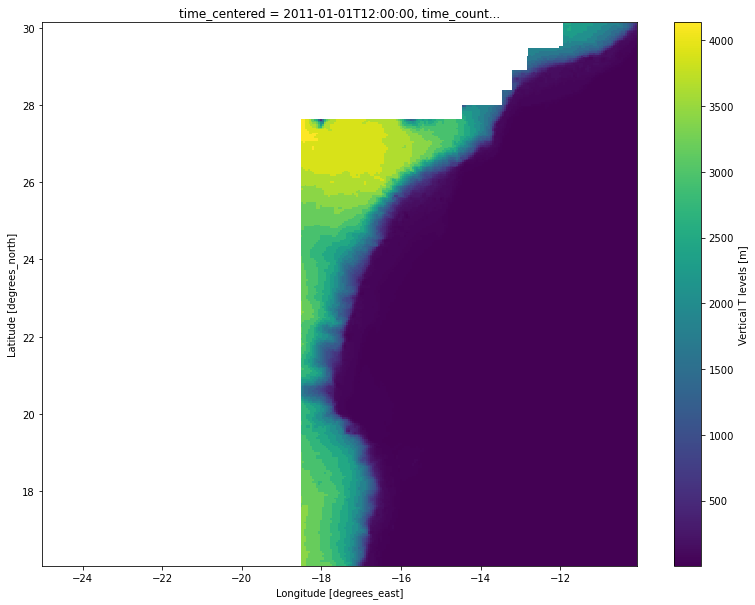

In [10]:
bath = depth_tgrid.squeeze()[1:,:-1]
#bath.plot()# bathy. at each bin 
bath_canary = bath.where((bath['nav_lat'] >=27.65)&(bath['nav_lon'] <=-14.45))
bath_canary2 = bath.where((bath['nav_lat'] >=28)&(bath['nav_lon'] <=-13.45))
bath_canary3 = bath.where((bath['nav_lat'] >=28.9)&(bath['nav_lon'] <=-12.8))
bath_fuerte = bath.where((bath['nav_lat'] >=28.4)&(bath['nav_lon'] <=-13.2))#cut eastern side of fuerteventure, Lanzarote
bath_smount = bath.where((bath['nav_lat'] >=29.5)&(bath['nav_lon'] <=-11.9))#cut  conception seamount

#for release zone
bath_relzone = bath.where((bath_canary == bath)&(bath['nav_lon'] >=-17)&(bath['nav_lon'] <=-16)&(bath>4)&(bath<500))
#bath_canary.plot(size = 10)
bath_fuerte.shape
#african shelf
bath_afr = bath.where((bath_canary != bath)&(bath_canary3 != bath)&(bath_canary2 != bath)&(bath_fuerte != bath)&(bath_smount != bath)&(bath['nav_lon'] >=-18.5))
bath_afr.shape
bath_afr.plot(x = 'nav_lon',y='nav_lat',size = 10)

In [11]:
import math
def haversine_distance(point_1, point_2):

    r_earth = 6371.0
    lat1_rad = math.radians(point_1['lat_bin'])
    lon1_rad = math.radians(point_1['lon_bin'])
    lat2_rad = math.radians(point_2['lat_bin'])
    lon2_rad = math.radians(point_2['lon_bin'])

    # differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return r_earth * c

Mean distance: 875.1669850219223
std: 190.1211047120046


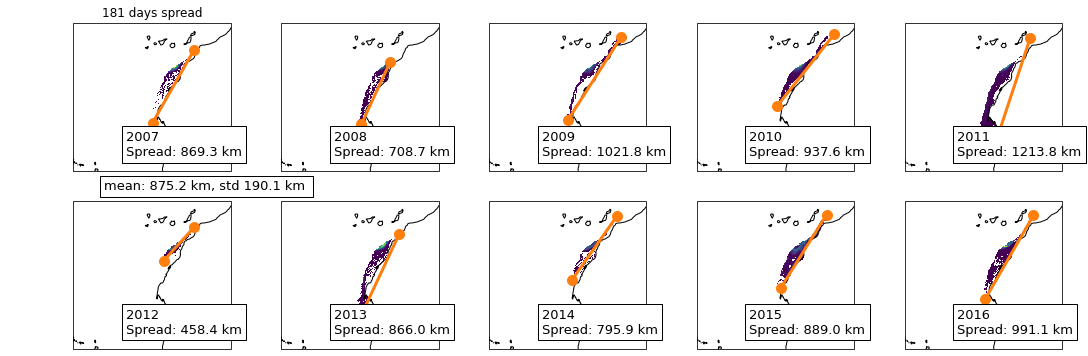

In [13]:
#test = hm_day.sortby('lat_bin', ascending = False)
fig, ax = plt.subplots(2, 5, subplot_kw={"projection": proj}, figsize=(18, 6))
distance_list180 = year_list.copy()

flat_axes = ax.ravel()
for i,ax in enumerate(flat_axes):
    hm_day = heatmap_list[i].sum('obs')
    hm_day = hm_day.where(hm_day > 0).where(bath_afr.values < 500)

    south_point = hm_day.dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = 0).coords #select southwesternmost point
    north_point = hm_day.sortby('lat_bin', ascending=False).dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = -1) #select north easternmost point
    distance_list180[i] = haversine_distance(south_point, north_point)


    hm_day.plot.pcolormesh(x = 'lon_bin', y = 'lat_bin',ax = ax, add_colorbar = False)
    ax.plot((south_point['lon_bin'],north_point['lon_bin']),(south_point['lat_bin'],north_point['lat_bin']), marker = '.', markersize = 20,lw = 3, c = 'tab:orange')
    ax.coastlines()
    ax.annotate(f'{year_list[i]}\nSpread: {np.round(distance_list180[i],1)} km',(-20.0,17.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    #ax.plot(north_point['lon_bin'],north_point['lat_bin'], marker = '*')

flat_axes[0].set_title('181 days spread')
flat_axes[0].annotate(f'mean: {np.round(np.mean(distance_list180),1)} km, std {np.round(np.std(distance_list180),1)} km ',
                      (0.08,0.385),bbox={"fc": "white", "ec": "k", "lw": 1}, xycoords = 'figure fraction',fontsize = 13 )#on africa

print(f'Mean distance: {np.mean(distance_list180)}')
print(f'std: {np.std(distance_list180)}')

Mean distance: 351.2910878535041
std: 174.18172374478863


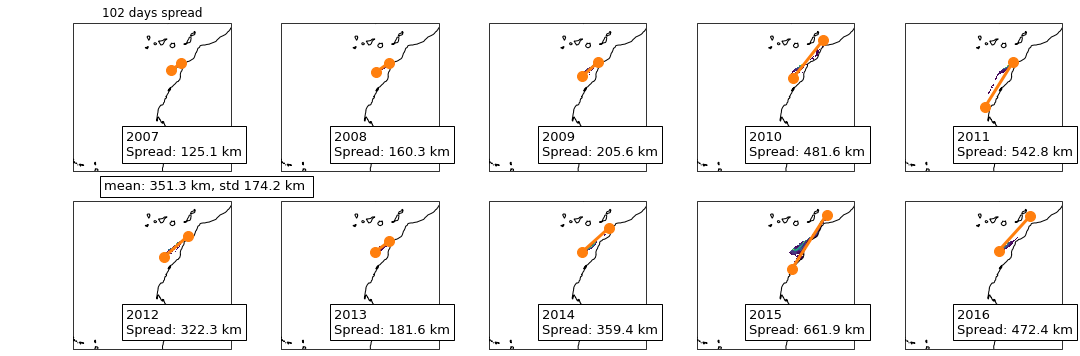

In [158]:
#short
fig, ax = plt.subplots(2, 5, subplot_kw={"projection": proj}, figsize=(18, 6))
distance_list100 = year_list.copy()

flat_axes = ax.ravel()
for i,ax in enumerate(flat_axes):
    hm_day = heatmap_list[i].isel(obs = slice(0,101)).sum('obs')
    hm_day = hm_day.where(hm_day > 0).where(bath_afr.values < 500)

    south_point = hm_day.dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = 0).coords #select southwesternmost point
    north_point = hm_day.sortby('lat_bin', ascending=False).dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = -1) #select north easternmost point
    distance_list100[i] = haversine_distance(south_point, north_point)


    hm_day.plot.pcolormesh(x = 'lon_bin', y = 'lat_bin',ax = ax, add_colorbar = False)
    ax.plot((south_point['lon_bin'],north_point['lon_bin']),(south_point['lat_bin'],north_point['lat_bin']), marker = '.', markersize = 20,lw = 3, c = 'tab:orange')
    ax.coastlines()
    ax.annotate(f'{year_list[i]}\nSpread: {np.round(distance_list100[i],1)} km',(-20.0,17.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    #ax.plot(north_point['lon_bin'],north_point['lat_bin'], marker = '*')

flat_axes[0].set_title('102 days spread') 
flat_axes[0].annotate(f'mean: {np.round(np.mean(distance_list100),1)} km, std {np.round(np.std(distance_list100),1)} km ',
                      (0.08,0.385),bbox={"fc": "white", "ec": "k", "lw": 1}, xycoords = 'figure fraction',fontsize = 13 )#on africa

print(f'Mean distance: {np.mean(distance_list100)}')
print(f'std: {np.std(distance_list100)}')

Text(0.5, 1.0, 'ensemble 181 days spread')

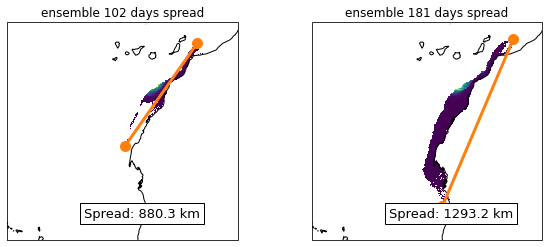

In [159]:
#spread of mean ensemble max extnt
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(10, 4))

ens_list = [ensemble_100_mean,ensemble_mean]
distance_list_10y = ens_list.copy()

flat_axes = ax.ravel()
for i,ax in enumerate(flat_axes):
    hm_day = ens_list[i]
    hm_day = hm_day.where(hm_day > 0).where(bath_afr.values < 500)

    south_point = hm_day.dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = 0).coords #select southwesternmost point
    north_point = hm_day.sortby('lat_bin', ascending=False).dropna(dim='lat_bin', how='all').isel(lat_bin=0).dropna(dim = 'lon_bin').isel(lon_bin = -1) #select north easternmost point
    distance_list_10y[i] = haversine_distance(south_point, north_point)


    hm_day.plot.pcolormesh(x = 'lon_bin', y = 'lat_bin',ax = ax, add_colorbar = False)
    ax.plot((south_point['lon_bin'],north_point['lon_bin']),(south_point['lat_bin'],north_point['lat_bin']), marker = '.', markersize = 20,lw = 3, c = 'tab:orange')
    ax.coastlines()
    ax.annotate(f'Spread: {np.round(distance_list_10y[i],1)} km',(-20.0,17.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    #ax.plot(north_point['lon_bin'],north_point['lat_bin'], marker = '*')

flat_axes[0].set_title('ensemble 102 days spread') 
flat_axes[1].set_title('ensemble 181 days spread') 

In [12]:
#get shelf trajs
#load Polygon 
from shapely.geometry import Polygon, Point
exterior = pd.read_csv(Path('../data/target_zone_shelf.csv')).values.tolist()
box_shelf = Polygon(exterior, [])  

def read_shelf_traj(file):
    out_ds = xr.open_dataset(file).compute()
    
    lat_outds = out_ds.isel(obs = 180)['lat'].values
    lon_outds = out_ds.isel(obs = 180)['lon'].values

    points = [Point(lon, lat) for lat, lon in zip(lat_outds, lon_outds)]
    indices = np.array([i for i, point in enumerate(points) if box_shelf.contains(point)])

    shelf_trajs = out_ds.isel(traj = indices)
    
    return shelf_trajs

def read_shelf_traj100(file):
    out_ds = xr.open_dataset(file).compute()
    
    lat_outds = out_ds.isel(obs = 101)['lat'].values
    lon_outds = out_ds.isel(obs = 101)['lon'].values

    points = [Point(lon, lat) for lat, lon in zip(lat_outds, lon_outds)]
    indices = np.array([i for i, point in enumerate(points) if box_shelf.contains(point)])

    shelf_trajs = out_ds.isel(traj = indices)
    
    return shelf_trajs

def load_shelf_traj(year, last_index = True):
    
    out_path = "/gxfs_work/geomar/smomw122/smomw529_2023_sea_urchin_tenerife/comp_output_data/full_weekly_runs/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))
    
    if last_index:
        ds = xr.concat(map(read_shelf_traj, out_files), dim="traj")
        print(f'loaded shelf traj from {len(out_files)} files in year {year}, {ds.traj.values[-1]} trajs')
    else:
        ds = xr.concat(map(read_shelf_traj100, out_files), dim="traj")
        print(f'loaded shelf traj (100days) from {len(out_files)} files in year {year}, {ds.traj.values[-1]} trajs')
    return ds

shelf_traj_list100 = year_list.copy()
shelf_traj_list180 = year_list.copy()
for i, year in enumerate(year_list):
    
    shelf_traj_list180[i] = load_shelf_traj(year)
    shelf_traj_list100[i] = load_shelf_traj(year, last_index = False)
shelf_traj180 = xr.concat(shelf_traj_list180, dim = 'traj')
shelf_traj100 = xr.concat(shelf_traj_list100, dim = 'traj')

loaded shelf traj from 52 files in year 2007, 577 trajs
loaded shelf traj (100days) from 52 files in year 2007, 36 trajs
loaded shelf traj from 52 files in year 2008, 1837 trajs
loaded shelf traj (100days) from 52 files in year 2008, 896 trajs
loaded shelf traj from 52 files in year 2009, 593 trajs
loaded shelf traj (100days) from 52 files in year 2009, 131 trajs
loaded shelf traj from 52 files in year 2010, 2962 trajs
loaded shelf traj (100days) from 52 files in year 2010, 1171 trajs
loaded shelf traj from 52 files in year 2011, 1969 trajs
loaded shelf traj (100days) from 52 files in year 2011, 234 trajs
loaded shelf traj from 52 files in year 2012, 956 trajs
loaded shelf traj (100days) from 52 files in year 2012, 144 trajs
loaded shelf traj from 52 files in year 2013, 1630 trajs
loaded shelf traj (100days) from 52 files in year 2013, 635 trajs
loaded shelf traj from 52 files in year 2014, 1298 trajs
loaded shelf traj (100days) from 52 files in year 2014, 409 trajs
loaded shelf traj f

In [13]:
#save
#shelf_traj180.to_netcdf(Path("../data/traj_onshelf180.nc"))
#shelf_traj100.to_netcdf(Path("../data/traj_onshelf100.nc"))


#slightly larger zone, but same Relative size in numbers 
print(f'number on shelf at day 181: {shelf_traj180.traj.values.shape}')
print(f'number on shelf at day 181: {shelf_traj100.traj.values.shape}')
print(f'fold: {shelf_traj180.traj.values.shape[0]/shelf_traj100.traj.values.shape[0]}')

number on shelf at day 181: (27696,)
number on shelf at day 181: (9495,)
fold: 2.9169036334913114


In [77]:

def haversine_distance_traj(start, end):

    r_earth = 6371.0
    
    lat1 = start['lat'].values[:, np.newaxis]
    lon1 = start['lon'].values[:, np.newaxis]
    lat2 = end['lat'].values[np.newaxis, :]
    lon2 = end['lon'].values[np.newaxis, :]
    
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r_earth * c

In [78]:
start = shelf_traj180.isel(obs = 0)
end = shelf_traj180.isel(obs = -1)

distance_particle_180 = haversine_distance_traj(start,end)
print(f'snapshot of number of particels at day 181 on shelf: {shelf_traj180.traj.values.shape}')
print(f'Mean distance travelled 181 days: {np.round(np.mean(distance_particle_180),1)} km')
print(f'std: {np.round(np.std(distance_particle_180),1)} km')

KeyboardInterrupt: 

<xarray.Dataset>
Dimensions:     (traj: 9610, obs: 101)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.41 -16.51 -16.63 ... -15.41 -15.39
    lat         (traj, obs) float64 28.11 28.03 28.01 ... 25.85 25.83 25.82
    z           (traj, obs) float64 29.77 42.83 47.86 51.89 ... 42.6 41.82 41.12
    time        (traj, obs) datetime64[ns] 2007-04-02 2007-04-03 ... 2017-02-23
    trajectory  (traj, obs) float64 256.0 256.0 256.0 ... 9.981e+03 9.981e+03
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [ ]:
#ERROR
start = shelf_traj100.isel(obs = slice(0,101))
end = shelf_traj100.isel(obs = slice(0,101))

distance_particle_100 = haversine_distance_traj(start,end)
print(f'snapshot of number of particels at day 181 on shelf: {shelf_traj100.traj.values[-1]}' )
print(f'Mean distance travelled 181 days: {np.round(np.mean(distance_particle_100),1)} km')
print(f'std: {np.round(np.std(distance_particle_100),1)} km')

In [35]:
canary_sum = np.zeros((10,180))
afr_sum = np.zeros((10,180))
for i,hm in enumerate(heatmap_list):
    #print(year_list[i])
    for j in range(180):
        hm_day = hm.isel(obs = j)
        canary_hm = np.where(bath_canary<500, hm_day, np.nan)
        afr_hm = np.where(bath_afr<=500, hm_day, np.nan)
        
       
        canary_sum[i,j] = np.nan_to_num(canary_hm).sum()
        afr_sum[i,j] = np.nan_to_num(afr_hm).sum()
        #print(f'At day {day}:  Canary: {canary_sum}; Africa {afr_sum}')

In [58]:
#shooese 50 random indices from trajectories for plot

#OG Plots
np.random.seed(12)
r_ind100 = random_integers = np.random.randint(0, shelf_traj100['traj'].shape[0], size=50) 
np.random.seed(11)
r_ind180 = random_integers = np.random.randint(0, shelf_traj180['traj'].shape[0], size=50) 

traj_180 = shelf_traj180.isel(traj = r_ind180[:25])
traj_100 = shelf_traj100.isel(traj = r_ind100[:25],obs = slice(0,101))

In [67]:
#shooese 50 random indices from trajectories for plot

#OG Plots
np.random.seed(12)
r_ind100 = random_integers = np.random.randint(0, shelf_traj100['traj'].shape[0], size=500) 
np.random.seed(14)
r_ind180 = random_integers = np.random.randint(0, shelf_traj180['traj'].shape[0], size=500) 

traj_180 = shelf_traj180
traj_100 = shelf_traj100.isel(obs = slice(0,101))

In [68]:
#test downsampling after calc heatmaps for smaller svg plots ()
afr_hm = np.where(bath_afr<500, ensemble_mean, np.nan)
afr_hm100 = np.where(bath_afr<500, ensemble_100_mean, np.nan)

x_ds =afr_hm100.shape[0] // 2
y_ds = afr_hm100.shape[1] // 2
x_bins = lon_bins.shape[0]//2
y_bins = lat_bins.shape[0]//2
#resahepe new arrays
afr_hm100_ds = afr_hm100[:x_ds * 2, :y_ds * 2].reshape(x_ds, 2, y_ds, 2)
afr_hm_ds = afr_hm[:x_ds * 2, :y_ds * 2].reshape(x_ds, 2, y_ds, 2)
lon_bins_ds = lon_bins[:x_bins * 2].reshape(x_bins, 2)
lat_bins_ds = lat_bins[:y_bins * 2].reshape(y_bins, 2)

#downsampling
afr_hm100_ds = afr_hm100_ds.mean(axis=(1, 3))
afr_hm_ds = afr_hm_ds.mean(axis=(1, 3))
lon_bins_ds  = lon_bins_ds .mean(axis=1)
lat_bins_ds = lat_bins_ds.mean(axis=1)

#low res meshgrid
x_mesh,y_mesh = np.meshgrid(lon_bins_ds[:-1],lat_bins_ds[:-1])
print(afr_hm100_ds.shape)
print(x_mesh.shape)

(153, 149)
(153, 149)


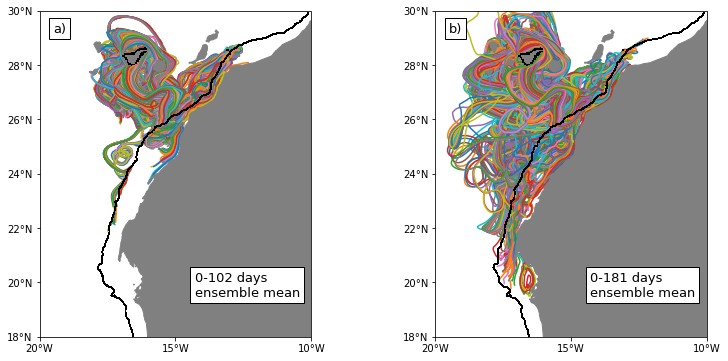

In [69]:

textbox = ["0-102 days\nensemble mean","0-181 days\nensemble mean"]
textbox2 = ["a)","b)"]
color2 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.YlOrRd(np.ones(2)*.8))
color0 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.Greys(np.ones(2)*1))

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(13, 6))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

#pc = ax[0].pcolormesh(x_mesh,y_mesh,np.where(afr_hm100>0, afr_hm100, np.nan), rasterized = True, cmap = new_cmap, norm=colors.SymLogNorm(linthresh=1, linscale=1,
#                                                       vmin=0, vmax=300, base=10))#, zorder = ))
#cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad*0.7, extend = 'max')
#cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


ax[0].plot(traj_100['lon'].T,
           traj_100['lat'].T, zorder = -1, rasterized = True)

#pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(afr_hm>0, afr_hm, np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
 #                                                      vmin=0, vmax=300, base=10), snap = True)#, zorder = ))
#cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad*0.7, extend = 'max')
#cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
ax[1].plot(traj_180['lon'].T,
           traj_180['lat'].T, zorder = -1, rasterized = True)

for i, axs in enumerate(ax.flat):
    

    
    axs.annotate(textbox[i],(-14.3,19.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    axs.annotate(textbox2[i],(-19.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc


            #misc

        #ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
    
    
    axs.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon[:-2,:-1], mesh_t_lat[:-2,:-1], bath_afr[1:,:], colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
    axs.pcolormesh(mesh_t_lon[1:,:], mesh_t_lat[1:,:],bath_relzone[:-1,:], cmap =color0, vmin = 1,vmax = 500,zorder = 4,rasterized = True) # release zone

    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-20,-10,18,30))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

skip = 15
qv_scale = 0.26

#qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', 
#                  scale = qv_scale, rasterized = True, scale_units='inches', width = .006,
#                transform = proj)
#ax[1].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', 
#             scale =qv_scale, rasterized = True, scale_units='inches',width = .006,
#                transform = proj)

#ax[0].quiverkey(qv, 1.2, 0.08, .1, r'$0.1 \frac{m}{s}$', labelpos='E', 
#                       coordinates='axes', rasterized = True)


#plt.savefig('pics/fig_S1_shelf_trajectories.svg', format = 'svg', dpi = 700) 
#plt.savefig('pics/fig_S1_shelf_trajectories_low_res.svg', format = 'svg')
#plt.savefig('pics/shelf_102_181_trajectories.png', dpi = 300, bbox_inches = 'tight') 

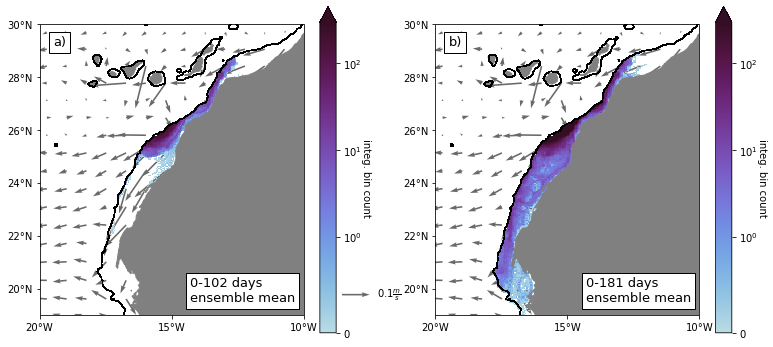

In [25]:
#OLD
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(13, 6))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

afr_hm = np.where(bath_afr<500, ensemble_mean, np.nan)
afr_hm100 = np.where(bath_afr<500, ensemble_100_mean, np.nan)

pc = ax[0].pcolormesh(x_mesh,y_mesh,np.where(afr_hm100>0, afr_hm100, np.nan), rasterized = True, cmap = new_cmap, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)

pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(afr_hm>0, afr_hm, np.nan), cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=300, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


for i, axs in enumerate(ax.flat):
    

    
    axs.annotate(textbox[i],(-14.3,19.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    axs.annotate(textbox2[i],(-19.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc


            #misc

        #ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
    
    
    axs.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon[1:,1:], mesh_t_lat[1:,1:], bath[:,:], colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
    #axs.pcolormesh(mesh_t_lon[1:,:], mesh_t_lat[1:,:],bath_relzone[:-1,:], cmap =color2, vmin = 1,vmax = 500,zorder = 4,rasterized = True) # release zone

    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-20,-10,19,30))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale =qv_scale, rasterized = True, #2.5
                  scale_units='inches', width = .006,zorder = -1,
                transform = proj)
ax[1].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = qv_scale, rasterized = True, #2.5
             scale_units='inches', width = .006,zorder = -1,
                transform = proj)

ax[0].quiverkey(qv, 1.25, 0.07, .1, r'$0.1 \frac{m}{s}$', labelpos='E', 
                       coordinates='axes',rasterized = True,zorder = -1,)

#1. NS
#2. OW
#fig.savefig('pics/fig_1_shelf_bins.svg', format = 'svg', dpi = 700) 
#fig.savefig('pics/fig_1_shelf_bins_low_res.svg', format = 'svg')

In [ ]:
afr_hm = xr.where(bath_afr<500, ensemble_mean, np.nan)
afr_hm100 = xr.where(bath_afr<500, ensemble_100_mean, np.nan)

In [ ]:
afr_hm.plot()

In [51]:
bath_canary.where((bath['nav_lon'] >= -17)&(bath['nav_lon'] < -17))

<xarray.DataArray 'deptht' (y: 265, x: 299)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    deptht         (y, x) float64 3.893e+03 3.893e+03 3.893e+03 ... 734.7 534.0
    nav_lat        (y, x) float32 18.09 18.09 18.09 18.09 ... 30.1 30.1 30.1
    nav_lon        (y, x) float32 -25.0 -24.95 -24.9 ... -10.19 -10.14 -10.09
    time_centered  datetime64[ns] 2011-01-01T12:00:00
    time_counter   datetime64[ns] 2011-01-01T12:00:00
Dimensions without coordinates: y, x
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    positive:   down
    bounds:     deptht_bounds

# Target zone timeseries

In [110]:
def count_in_shallow(mean_sum):
    return np.cumsum(np.where(np.ediff1d(mean_sum)>0, np.ediff1d(mean_sum),0))

(0.0, 12000.0)

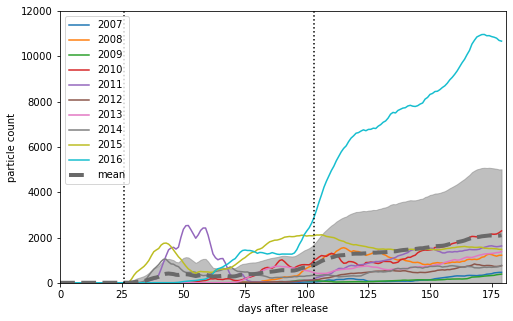

In [38]:
plt.figure(figsize = (8,5))
for i in range(10):
    plt.plot(afr_sum[i,:], label = str(year_list[i]))

neg_std = np.mean(afr_sum, axis = 0) - np.std(afr_sum, axis = 0)
pos_std = np.mean(afr_sum, axis = 0) + np.std(afr_sum, axis = 0)
plt.fill_between(range(180),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5)
plt.plot(np.mean(afr_sum, axis = 0), lw = 4,c = 'dimgrey',ls = '--', label = 'mean')
plt.vlines(26,0,12e3,ls = ':', color = '00')
plt.vlines(103,0,12e3,ls = ':', color = '00')

plt.legend()

plt.xlabel('days after release')
plt.ylabel('particle count')
plt.xlim(0,181)
plt.ylim(0,12e3)

#plt.savefig('pics/shelf_timeline_yearly_old.png', dpi = 300, bbox_inches = 'tight') 

# Export data used in S24 annual-variation plot (all plotted series)
_scale_factor = 10  # same scaling used in the plotted integrated curves
_yearly_curves = np.vstack([
    count_in_shallow(afr_sum[i, :]) * _scale_factor
    for i in range(len(year_list))
])
_mean_curve = count_in_shallow(np.mean(afr_sum, axis=0)) * _scale_factor
_afr_cumsum = np.zeros_like(afr_sum, dtype=float)
for i in range(len(year_list)):
    _afr_cumsum[i, 1:] = count_in_shallow(afr_sum[i, :]) * _scale_factor
_std_curve = np.std(_afr_cumsum, axis=0)[1:]
_lower = np.where(_mean_curve - _std_curve < 0, 0, _mean_curve - _std_curve)
_upper = _mean_curve + _std_curve
_days = np.arange(1, _mean_curve.shape[0] + 1)

data_df = pd.DataFrame({
    'day': _days,
    'mean': _mean_curve,
    'lower': _lower,
    'upper': _upper,
})
for i, year in enumerate(year_list):
    data_df[f'year_{year}'] = _yearly_curves[i, :]

data_df.to_csv('../data/fig_S24_annual_variation.csv', index=False)
print('Wrote ../data/fig_S24_annual_variation.csv')


In [46]:
#particles on shelf 
print(f'number on shelf at day 102 {afr_sum[:,101].sum()}')
print(f'number on shelf at day 181 {afr_sum[:,-1].sum()}')


print(f'10y std  at day 102 {afr_sum[:,101].std()}')
print(f'10y std at day 181 {afr_sum[:,-1].std()}')
fold = np.round(afr_sum[:,-1].mean() / afr_sum[:,101].mean(),2)
print(f'{fold} fold')

number on shelf at day 102 7191.0
number on shelf at day 181 21019.0
10y std  at day 102 811.0164548269042
10y std at day 181 2908.767658304802
2.92 fold


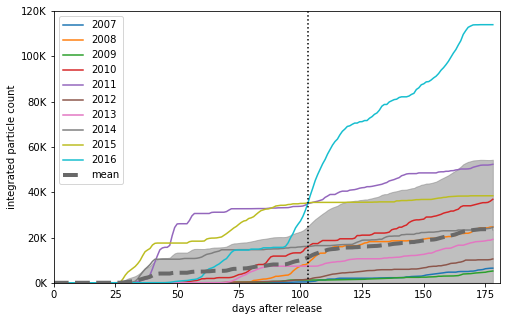

In [123]:
import matplotlib.ticker as ticker
scale_factor = 10 #520k per year scaled to 5.2mill
afr_cumsum = np.zeros_like(afr_sum)


plt.figure(figsize = (8,5))
for i in range(10):
    afr_cumsum[i,1:] = count_in_shallow(afr_sum[i,:]) * scale_factor
    plt.plot(count_in_shallow(afr_sum[i,:])*scale_factor, label = str(year_list[i]), zorder = 2)

plt.plot(count_in_shallow(np.mean(afr_sum, axis = 0))*scale_factor, lw = 4,c = 'dimgrey',ls = '--', label = 'mean')
neg_std = count_in_shallow(np.mean(afr_sum, axis = 0)) *scale_factor - np.std(afr_cumsum, axis = 0)[1:]
pos_std = count_in_shallow(np.mean(afr_sum, axis = 0)) *scale_factor+ np.std(afr_cumsum, axis = 0)[1:] 

#plt.plot(count_in_shallow(np.mean(afr_sum, axis = 0)), lw = 4, label = 'mean')
plt.fill_between(range(len(pos_std)),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5, zorder = 0)
plt.legend()
#plt.vlines(26,0,300e3,ls = ':', color = '00')
plt.vlines(103,0,300e3,ls = ':', color = '00')

plt.xlabel('days after release')
plt.ylabel('integrated particle count')
plt.xlim(0,181)
plt.ylim(0,120e3)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))
plt.savefig('pics/shelf_timeline_yearly_integ.svg', format = 'svg', dpi = 700) 

(0.0, 200.0)

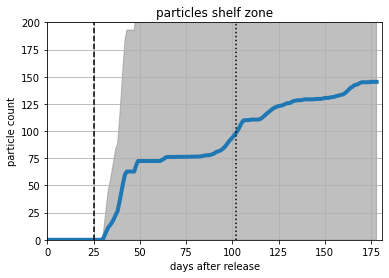

In [49]:
neg_std = np.mean(afr_sum, axis = 0) - np.std(afr_sum, axis = 0)
pos_std = np.mean(afr_sum, axis = 0) + np.std(afr_sum, axis = 0)

plt.plot(count_in_shallow(np.mean(afr_sum, axis = 0)), lw = 4, label = 'mean')
plt.fill_between(range(len(pos_std)),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5)
plt.grid()
plt.title('particles shelf zone')
plt.xlabel('days after release')
plt.ylabel('particle count')
plt.xlim(0,181)
plt.vlines(25,0,200,ls = 'dashed', color = '00')
plt.vlines(102,0,200,ls = ':', color = '00')
plt.ylim(0,200)

#plt.savefig('pics/shelf_timeline.png', dpi = 300, bbox_inches = 'tight') 

In [91]:
np.mean(afr_sum, axis = 0)[-1]

35.40990800865801

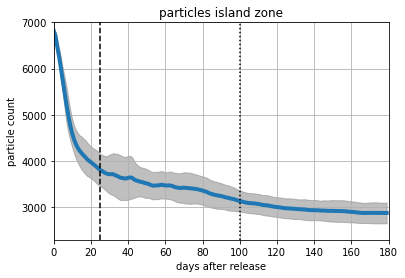

In [79]:
neg_std = np.mean(canary_sum, axis = 0) - np.std(canary_sum, axis = 0)
pos_std = np.mean(canary_sum, axis = 0) + np.std(canary_sum, axis = 0) 

plt.plot(np.mean(canary_sum, axis = 0), lw = 4, label = 'mean')
plt.fill_between(range(180),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5)

plt.grid()
plt.title('particles island zone')
plt.xlabel('days after release')
plt.ylabel('particle count')
plt.xlim(0,180)
plt.vlines(25,2300,7000,ls = 'dashed', color = '00')
plt.vlines(100,2300,7000,ls = ':', color = '00')
plt.ylim(2300,7000)

plt.savefig('pics/island_timeline.png', dpi = 300, bbox_inches = 'tight') 

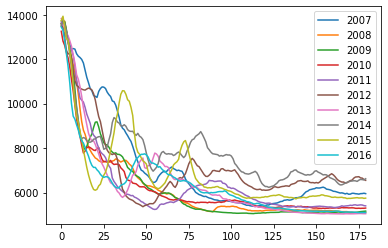

In [107]:
for i in range(10):
    plt.plot(canary_sum[i,:], label = str(year_list[i]))

plt.legend()
    

loaded 1 files in year alt_2016


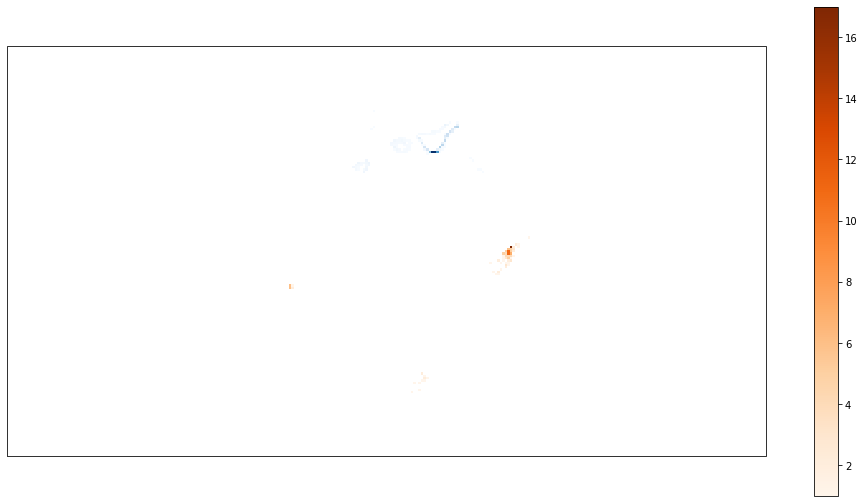

In [101]:
alt_ds, _ = load_ds('alt_2016')
alt_hm = calculate_heatmap(alt_ds, lat_bins, lon_bins)

canary_alt = np.zeros(180)
afr_alt = np.zeros(180)

for j in range(180):

    hm_day = alt_hm.isel(obs = j)
    canary_hm = np.where(bath_canary<500, hm_day, np.nan)
    afr_hm = np.where(bath_afr<500, hm_day, np.nan)

    canary_alt[j] = np.nan_to_num(canary_hm).sum()
    afr_alt[j] = np.nan_to_num(afr_hm).sum()
        #print(f'At day {day}:  Canary: {canary_sum}; Africa {afr_sum}')

      
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(17, 9))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

pc = ax.pcolormesh(x_mesh,y_mesh,canary_hm, cmap = 'Blues')
pc = ax.pcolormesh(x_mesh,y_mesh,afr_hm, cmap = 'Oranges')
fig.colorbar(pc)

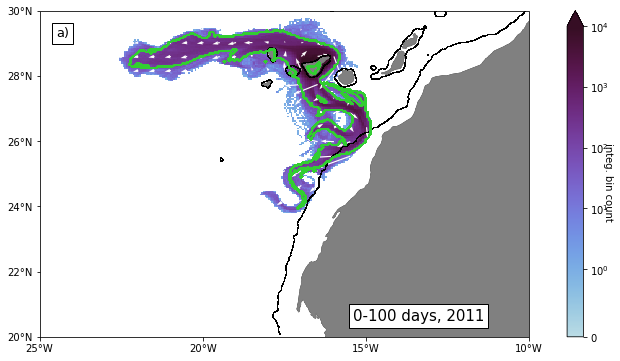

In [72]:
#plot 2011
u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[4]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[4]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

u_mean2011 = u_conc.mean('year')
v_mean2011 = v_conc.mean('year')

hm_2011 = heatmap_list[4].isel(obs = slice(0,60)).sum('obs')

quants = hm_2011.quantile(q=0.95) # 95% percentile
hm_t = quants.coords["quantile"].where(hm_2011 > quants)

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(14, 6))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)




pc = ax.pcolormesh(x_mesh,y_mesh,hm_2011.where(hm_2011 > 0), cmap = new_cmap, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=1e4, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax, pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270)




qv = ax.quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean2011[::skip,::skip], v_mean2011[::skip,::skip], color = 'white', scale = 2.5,
                transform = proj)
ax.quiverkey(qv, 55, .52, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                       coordinates='figure')
ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
ax.annotate('0-100 days, 2011',(-15.4,20.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 15 )#on africa
ax.annotate('a)',(-24.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc


            #misc
ax.coastlines()
        #ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)


ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.4,antialiased = False, levels = [500])
ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
ax.set_extent((x_lines[0],x_lines[-1],y_lines[0],30))
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
plt.savefig('pics/shelf2016.png', dpi = 300, bbox_inches = 'tight') 

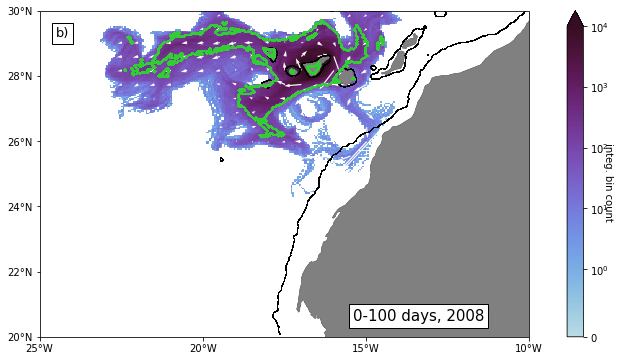

In [71]:
#plot 2008
u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[-2]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[-2]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

u_mean2011 = u_conc.mean('year')
v_mean2011 = v_conc.mean('year')

hm_2011 = heatmap_list[-2].isel(obs = slice(0,100)).sum('obs')

quants = hm_2011.quantile(q=0.95) # 95% percentile
hm_t = quants.coords["quantile"].where(hm_2011 > quants)

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(14, 6))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)




pc = ax.pcolormesh(x_mesh,y_mesh,hm_2011.where(hm_2011 > 0), cmap = new_cmap, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                                       vmin=0, vmax=1e4, base=10))#, zorder = ))
cbar = fig.colorbar(pc, ax =ax, pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270)




qv = ax.quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean2011[::skip,::skip], v_mean2011[::skip,::skip], color = 'white', scale = 2.5,
                transform = proj)
ax.quiverkey(qv, 55, .52, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                       coordinates='figure')
ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
ax.annotate('0-100 days, 2008',(-15.4,20.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 15 )#on africa
ax.annotate('b)',(-24.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc


            #misc
ax.coastlines()
        #ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)


ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
ax.contour(mesh_t_lon, mesh_t_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.4,antialiased = False, levels = [500])
ax.contour(lon,lat, hm_t.fillna(0), colors = "limegreen", linewidths = 0.2,antialiased = False)
ax.set_extent((x_lines[0],x_lines[-1],y_lines[0],30))
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
plt.savefig('pics/shelf2008.png', dpi = 300, bbox_inches = 'tight') 

In [159]:
def heatmap_diff(ds, title, year, month, depth_ind, save = False):
    
    ds, _ = load_ds(year)
    print(f"print: {outfile}")
    #Border lat/lon of full domain
    lat_min = ds.lat.min().persist()
    lat_max = ds.lat.max().persist()
    lon_min = ds.lon.min().persist()
    lon_max = ds.lon.max().persist()

    print(f"lat in [{lat_min.compute().data}, {lat_max.compute().data}]")
    print(f"lon in [{lon_min.compute().data}, {lon_max.compute().data}]")
    #binsize

    dlat = 0.1 #binsize
    dlon = 0.1
    lat_bins = np.arange(lat_min.compute().data, lat_max.compute().data + dlat, dlat)
    lon_bins = np.arange(lon_min.compute().data, lon_max.compute().data + dlon, dlon)
    print(f"{len(lat_bins)} lat bins")
    print(f"{len(lon_bins)} lon bins")
    timeframe_ind = [int(100*24/output_dt_in_h), int(180*24/output_dt_in_h),int(180*24/output_dt_in_h)] 

    

    #x_lines = [-30, -20,-10]
    x_lines = [-25, -20,-15,-10]
    y_lines = [22,24,26,28,30]
    ticks = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
    cb_pad = 0.07
    cb_fraction = 0.047
    proj = ccrs.PlateCarree()
    box_size = 0.25
    box_lon = -16.3
    box_lat = 28.4
    textbox = ["0-100 days\nno photosynthesis","0-180 days\nwith photosynthesis",'difference\n b) - a)']
    textbox2 = ["a)","b)", "c)"]
    cmap = cmocean.cm.dense
    new_cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)
    formatter = LogFormatter(10, labelOnlyBase=False)
    

    int_heat,psum = calc_mort_heatmap(ds, lat_bins=lat_bins, lon_bins=lon_bins)
    lon = int_heat["lon_bin"]
    lat = int_heat["lat_bin"]
    
    fig, ax = plt.subplots(2, 2, subplot_kw={"projection": proj}, figsize=(17, 9))

    for i, ax in enumerate(ax.flat):
        if i ==3:
            fig.delaxes(ax)
            break
            
        #i == 0 -> no photo
        
        #only in last
        if i==2:
            
            
            #heatmap and 95% contour 
            ds = read_output(outfile)
            int_heat_nop, particle_sum_nop = calc_mort_heatmap(ds, photo = False,lat_bins=lat_bins, lon_bins=lon_bins)
            int_heat_phot, particle_sum_phot = calc_mort_heatmap(ds, photo = True,lat_bins=lat_bins, lon_bins=lon_bins)
            
            plot_heat_nop = (int_heat_nop/particle_sum_nop).where(int_heat_nop > 0)
            plot_heat_phot = (int_heat_phot/particle_sum_phot).where(int_heat_phot > 0)
            
            int_diff = (plot_heat_phot-plot_heat_nop)*100
            print(int_diff.max())
            print(int_diff.min())
            int_diff.plot(ax = ax,cmap = "seismic",levels = np.linspace(-.18,.18,25))#,norm=colors.SymLogNorm(linthresh=.1, linscale=1,
                                                   #    vmin=-1e1, vmax=1e1,
                                                   #                  base=10), extend = 'both')#, zorder = )
            #ticks = [-1e3,-1e2,-50,-10,0,10,50,1e2,1e3] 
            #ticks = [.1,0,-.1] 
            cbar = ax.collections[-1].colorbar
            #cbar.set_ticks(ticks, format = formatter)
            #cbar.set_ticklabels(ticks)
            cbar.set_label(' $\Delta$%', rotation=270)
            
        else:
            ds = read_output(outfile)
            
            #heatmap and 95% contour 
            int_heat,particle_sum = calc_mort_heatmap(ds,photo = i, lat_bins=lat_bins, lon_bins=lon_bins)
            lon = int_heat["lon_bin"]
            lat = int_heat["lat_bin"]
        
            #first 2 plots probability histograms
            plot_heat = (int_heat/particle_sum).where(int_heat > 0)
            
            (plot_heat*100).plot(ax = ax,cmap = new_cmap, norm=colors.SymLogNorm(linthresh=0.01, linscale=1,
                                                          vmin=0, vmax=0.7,
                                                                     base=10), extend = 'max')    
            cbar = ax.collections[-1].colorbar
            cbar.set_ticks(ticks, format = formatter)
            cbar.set_ticklabels(ticks)
            cbar.set_label('probability in %', rotation=270)
            
            quants = plot_heat.quantile(q=0.95) # 95% percentile
            hm_t = quants.coords["quantile"].where(plot_heat > quants)
            ax.contour(lon,lat, hm_t.fillna(0), colors = "00", linewidths = 0.2,antialiased = False)

        #release box
       
            #rel_zone = patches.Rectangle((box_lon-box_size, box_lat-box_size), box_size*2,box_size*2,
            #                edgecolor = 'red', facecolor = 'red', linewidth = 3)
            #ax.add_patch(rel_zone)
        
        #quiverplot
        skip = 10
        qv = ax.quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = 2.5,
            transform = proj)
        ax.quiverkey(qv, .58, .54, .2, r'$0.2 \frac{m}{s}$', labelpos='E', 
                   coordinates='figure')
        ax.annotate(textbox[i],(-15.5,22.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
        ax.annotate(textbox2[i],(-24.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc
        #misc
        ax.coastlines()
        
        ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)

        ax.set_extent((x_lines[0],x_lines[-1],y_lines[0],30))
        ax.set_xticks(x_lines, crs=proj)
        ax.set_yticks(y_lines, crs=proj)
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter()) 

        ax.set_title(title)


            
    plt.tight_layout()
    if save:
        plt.savefig('pics/' + save, dpi = 300, bbox_inches = 'tight')

    return plot_heat_nop,plot_heat_phot